<a href="https://colab.research.google.com/github/simon-bouchard/freecodecamp-machine-learning-models/blob/main/fcc_cat_dog_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2

import os
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 50
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-12-31 21:59:12--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.2’

cats_and_dogs.zip.2 100%[===================>]  67.43M   140MB/s    in 0.5s    

2024-12-31 21:59:13 (140 MB/s) - ‘cats_and_dogs.zip.2’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: cats_and_dogs/train/.DS_Store  


In [ ]:
#Clean non-image files

# Function to validate image files
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Check if it's a valid image
        return True
    except (IOError, SyntaxError):
        return False

for root, _, files in os.walk('cats_and_dogs/train'):
    for file in files:
        file_path = os.path.join(root, file)
        if not is_valid_image(file_path):
            print(f"Removing invalid file: {file_path}")
            os.remove(file_path)

Removing invalid file: cats_and_dogs/train/.DS_Store


In [ ]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    'cats_and_dogs/train',
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = batch_size,
    class_mode = 'binary'
)

val_data_gen = train_image_generator.flow_from_directory(
    'cats_and_dogs/validation',
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = batch_size,
    class_mode = 'binary'
)

test_dir = 'cats_and_dogs/test'
images = []
filenames = []
for file_name in sorted(os.listdir(test_dir)):  # Sort to maintain consistent order
    file_path = os.path.join(test_dir, file_name)
    if file_name.endswith(('png', 'jpg', 'jpeg')):  # Filter valid image files
        img = load_img(file_path, target_size=(IMG_WIDTH, IMG_HEIGHT))  # Resize image
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        filenames.append(file_name)

x_test = np.array(images)

test_data_gen = ImageDataGenerator().flow(
    x=x_test,
    batch_size=batch_size,
    shuffle=False
)

print(f"Number of batches: {len(test_data_gen)}")
for i, batch in enumerate(test_data_gen):
    print(f"Batch {i + 1} shape: {batch.shape}")
    if i == 0:  # Only check the first batch
        break

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Number of batches: 1
Batch 1 shape: (50, 150, 150, 3)


In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
#plotImages(sample_training_images[:5])


In [ ]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)



In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
    )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

#plotImages(augmented_images)

Found 2000 images belonging to 2 classes.


In [ ]:
#Count Images

def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += sum(1 for file in files if file.lower().endswith(('png', 'jpg', 'jpeg')))
    return count

train_image_count = count_images('cats_and_dogs/train')
val_image_count = count_images('cats_and_dogs/validation')

print(f"Number of training images: {train_image_count}")
print(f"Number of validation images: {val_image_count}")

print(f"Training image count from generator: {train_data_gen.samples}")
print(f"Validation image count from generator: {val_data_gen.samples}")


Number of training images: 2000
Number of validation images: 1000
Training image count from generator: 2000
Validation image count from generator: 1000


In [ ]:
# 7
#Use base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout to reduce overfitting
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

<ipython-input-9-ed7c480619b9>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#wrap dataset

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_data_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

# Prefetch for performance
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
# 8
steps_per_epoch = len(train_data_gen)
validation_steps = len(val_data_gen)

'''

class BatchShapeLogger(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print(f"Batch {batch + 1} completed")

class SanityCheck(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        x_batch, y_batch = next(train_data_gen)
        if x_batch is None or y_batch is None:
            print(f"Sanity Check Failed at Epoch {epoch + 1}")
            self.model.stop_training = True

'''

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data = val_dataset,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7633 - loss: 0.5820 - val_accuracy: 0.9470 - val_loss: 0.1324
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8992 - loss: 0.2398 - val_accuracy: 0.9550 - val_loss: 0.1196
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8989 - loss: 0.2258 - val_accuracy: 0.9620 - val_loss: 0.1027
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9093 - loss: 0.2111 - val_accuracy: 0.9500 - val_loss: 0.1308
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9093 - loss: 0.2271 - val_accuracy: 0.9570 - val_loss: 0.1104
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9099 - loss: 0.2052 - val_accuracy: 0.9530 - val_loss: 0.1145


In [ ]:
#Retrain the base model to fine tune it

model = tf.keras.models.load_model('cats_dogs_model_pretrained.keras')

#set base model to trainable wiith low learning rate
base_model.trainable = True

steps_per_epoch = len(train_data_gen)
validation_steps = len(val_data_gen)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data = val_dataset,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[model_checkpoint]
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9237 - loss: 0.1765 - val_accuracy: 0.9560 - val_loss: 0.1152
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9242 - loss: 0.1877 - val_accuracy: 0.9550 - val_loss: 0.1169
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9117 - loss: 0.2030 - val_accuracy: 0.9550 - val_loss: 0.1187
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9189 - loss: 0.1826 - val_accuracy: 0.9550 - val_loss: 0.1183
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9357 - loss: 0.1694 - val_accuracy: 0.9540 - val_loss: 0.1200
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9218 - loss: 0.1772 - val_accuracy: 0.9540 - val_loss: 0.1210
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9203 - loss: 0.1796 - val_accuracy: 0.9540 - val_loss: 0.1207
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9191 - loss: 0.1888 - val_accuracy: 0.9540 - val_loss:

ValueError: x and y must have same first dimension, but have shapes (15,) and (8,)

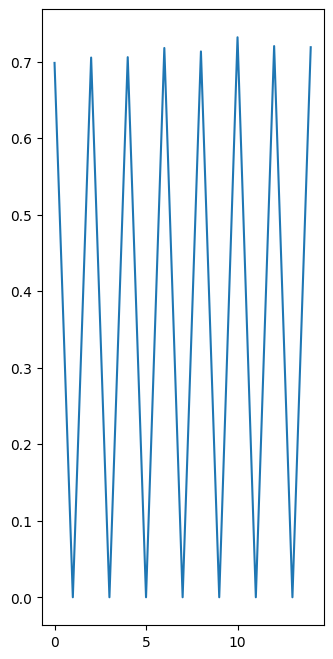

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model = tf.keras.models.load_model('cats_dogs_model_pretrained.keras')

In [ ]:
predictions = model.predict(test_data_gen)
probabilities = (predictions > 0.5).astype(int).flatten()
probabilities = probabilities.tolist()

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 92.0% of the images of cats and dogs.
You passed the challenge!


In [ ]:
# save model

model.save('cats_dogs_model_pretrained.keras')